<a href="https://colab.research.google.com/github/apoorvrocks/Machine-Learning-Assignment-1/blob/main/Ass2_Q6_BLOOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
import pickle

### LAYERS

In [8]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

In [9]:
from scipy import signal

class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size):
        input_depth, input_height, input_width = input_shape
        self.depth = input_depth
        self.input_shape = input_shape
        self.kernel_depth = input_depth
        self.output_shape = (input_depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (input_depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        # print('input', input.shape)
        # print('conv in', self.input_shape)
        # print('conv out', self.output_shape)
        for i in range(self.depth):
            for j in range(self.kernel_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)
        for i in range(self.depth):
            for j in range(self.kernel_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [10]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [11]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [12]:
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

In [13]:
class Maxpool(Layer):
    def __init__(self, input_shape, kernel_size):
        input_depth, input_height, input_width = input_shape
        self.depth = input_depth
        self.input_shape = input_shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernel_size = kernel_size

    def forward(self, input):
        # print('max input', input.shape)
        # print('max in', self.input_shape)
        # print('max out', self.output_shape)
        output_conv = np.zeros(self.output_shape)
        self.maxargs = np.zeros((self.output_shape[0], self.output_shape[1], self.output_shape[2], 2))
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    mat = input[d, i:self.kernel_size + i, j:self.kernel_size+j]
                    indices = np.where(mat == mat.max())
                    try:
                        output_conv[d, i, j] = mat[indices[0][0], indices[1][0]]
                        self.maxargs[d, i, j] = [indices[0][0]+i, indices[1][0]+j]
                    except IndexError:
                        print(indices)
                        print(mat)
                        raise Exception("Nan in maxpool")
        return output_conv

    def backward(self, output_gradient, learning_rate):
        back_layer = np.zeros(self.input_shape)
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    ind = self.maxargs[d, i, j]
                    back_layer[d, int(ind[0]), int(ind[1])] = output_gradient[d, i, j]
        return back_layer

In [14]:
class Avgpool(Layer):
    def __init__(self, input_shape, kernel_size):
        input_depth, input_height, input_width = input_shape
        self.depth = input_depth
        self.input_shape = input_shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernel_size = kernel_size

    def forward(self, input):
        output_conv = np.zeros(self.output_shape)
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    output_conv[d, i, j] = np.mean(input[d, i:self.kernel_size + i, j:self.kernel_size+j])
        return output_conv

    def backward(self, output_gradient, learning_rate):
        count_layer = np.zeros(self.input_shape)
        back_layer = np.zeros(self.input_shape)
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    count_layer[d, i:self.kernel_size + i, j:self.kernel_size+j] += 1
                    back_layer[d, i:self.kernel_size + i, j:self.kernel_size+j] += output_gradient[d, i, j]
        return back_layer / count_layer

### ACTIVATION LAYER

In [15]:
class Activation(Layer):
    def __init__(self, activation, activation_prime, *args):
        self.params = args
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input, self.params)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input, self.params))

In [16]:
def sigmoid(x, args):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime( x, args):
    s = sigmoid(x, args)
    return s * (1 - s)

def tanh(x, args):
    return np.tanh(x)

def tanh_prime(x, args):
    return 1 - np.tanh(x) ** 2

def relu(x, args):
    return np.maximum(x, 0)

def relu_prime(x, args):
    return (x>0).astype(x.dtype)

def lkrelu(x, args):
    a = np.maximum(x, 0)
    b = np.minimum(x * args[0], 0)
    return a + b

def lkrelu_prime(x, args):
    a = (x>0).astype(x.dtype)
    b = (x<0).astype(x.dtype) * args[0]
    return a + b

In [17]:
class Tanh(Activation):
    def __init__(self):
        super().__init__(tanh, tanh_prime)


class Sigmoid(Activation):
    def __init__(self):
        super().__init__(sigmoid, sigmoid_prime)


class Relu(Activation):
    def __init__(self):
        super().__init__(relu, relu_prime)


class LkRelu(Activation):
    def __init__(self, lk_const):
        super().__init__(lkrelu, lkrelu_prime, lk_const)

## **Loss** functions

In [18]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)


### Train and Predict functions

In [19]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    errors = []
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)
            
            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        errors.append(error)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")
    print(loss, learning_rate, errors)

### Load BloodMNIST dataset

In [20]:
data_path = '/content/drive/MyDrive/IISc/PRNN/bloodmnist.npz'

data = np.load(data_path)
print('DATA FILES:', data.files)

X_train = data['train_images'].reshape(data['train_images'].shape[0],-1)
X_test = data['test_images'].reshape(data['test_images'].shape[0],-1)
X_val = data['val_images'].reshape(data['val_images'].shape[0],-1)
Y_train = data['train_labels']
Y_test = data['test_labels']
Y_val = data['val_labels']

DATA FILES: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']


### Display data

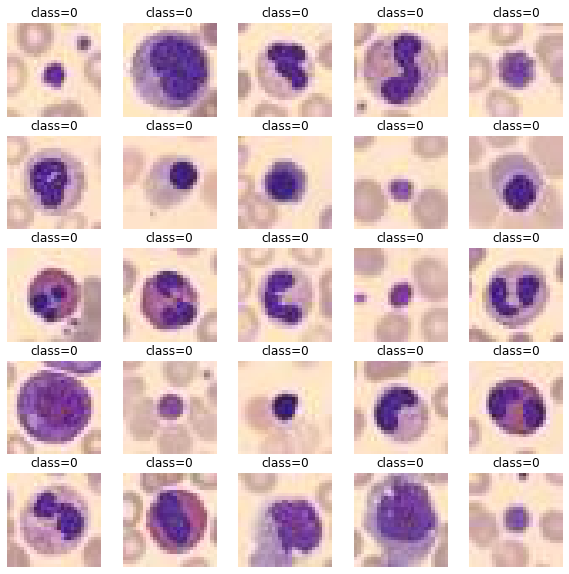

In [21]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(25):
    plt.subplot(5,5,i+1).set_title(f'class={np.argmax(Y_train[i])}')   # the number of images in the grid is 5*5 (25)
    plt.imshow(X_train[i].reshape(28,28,3))
    plt.axis('off')
plt.show()

### data preprocessing

In [22]:
def preprocess_data(x, y, no_classes,limit=None):
    x = x[:limit]
    y = y[:limit]
    x = x.reshape(len(x), 3, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), no_classes, 1)
    return x, y

no_classes = 8
x_train, y_train = preprocess_data(X_train, Y_train, no_classes)
x_test, y_test = preprocess_data(X_test, Y_test, no_classes)
x_val, y_val = preprocess_data(X_val, Y_val, no_classes)

In [23]:
X_train.shape

(11959, 2352)

### EXPERIMENTS

In [24]:
depth = 3
img_size = 28
kernel_size = 3
l1_size = img_size - kernel_size + 1
l2_size = l1_size - kernel_size + 1
l3_size = l2_size - kernel_size + 1
l4_size = l3_size - kernel_size + 1
no_class = 8

In [25]:
for lr in [0.03]:

    print('learning rate: ', lr)
    network = [
        Convolutional((3, 28, 28), kernel_size),
        # LkRelu(0.1),
        # Sigmoid(),
        Tanh(),
        Maxpool((depth, l1_size, l1_size), kernel_size),
        # Avgpool((depth, l1_size, l1_size), kernel_size),

        Convolutional((3, 24, 24), kernel_size),
        # LkRelu(0.1),
        # Sigmoid(),
        Tanh(),
        Maxpool((depth, l3_size, l3_size), kernel_size),
        # Avgpool((depth, l3_size, l3_size), kernel_size),
        
        Reshape((depth, l4_size, l4_size), (depth * l4_size * l4_size, 1)),
        Dense(depth * l4_size * l4_size, no_class),
        Sigmoid(),
        Softmax()
    ]
    train(network, mse, mse_prime, x_train[:2000], y_train[:2000], epochs=20, learning_rate=lr)


    filename = '/content/drive/MyDrive/IISc/PRNN/blood_saved_models/BLOOD_mse_tanh_max' + str(lr) + '.sav'
    pickle.dump(network, open(filename, 'wb'))



In [26]:
def plot_error(lkrelu, tan, sig, title_name):
    x = range(1, 21)
    
    plt.plot(x, lkrelu, label = "lkrelu")
    plt.plot(x, tan, label = "tan")
    plt.plot(x, sig, label = "sig")

    plt.xlabel('iteration')

    plt.ylabel('training error')
    plt.xticks(np.arange(0, 21, 5.0))
    plt.legend()

    plt.title(title_name)

    plt.show()



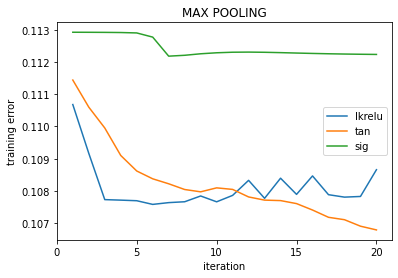

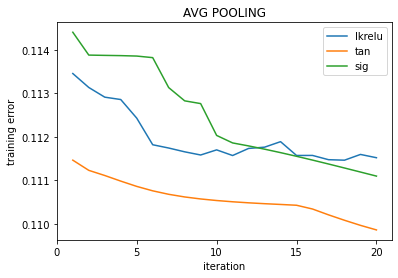

In [27]:
th = [0.1114412621031525, 0.11059976386323231, 0.10995315023580252, 0.10910012085618044, 0.10861822133731293, 0.10837560042986394, 0.10822118042874136, 0.1080434645369406, 0.10797149536324495, 0.10809460857183013, 0.10804662391110346, 0.10781259226632152, 0.10771390893371867, 0.10769939824823967, 0.10760597938032185, 0.1074065121607224, 0.10718060209074151, 0.10710612212249346, 0.10690505076325835, 0.10678914549001695]
lrelu = [0.11068069156070157, 0.10916608652822692, 0.10772954918747926, 0.10771363793475848, 0.10769530290366909, 0.10758139954694593, 0.10763631204029155, 0.10766345096859715, 0.10784251791255128, 0.10766157887206942, 0.10786086127963126, 0.10832763706264967, 0.10776980363175055, 0.10839437097762072, 0.10789224543662908, 0.10846497777795112, 0.10788247310017704, 0.10780677933613163, 0.10782761224328587, 0.1086582195266243]
sig = [0.11292504491878301, 0.11292350767146571, 0.11292100260786991, 0.11291621521595474, 0.11290345535096193, 0.11277392524073857, 0.11218266770718857, 0.11220974246621206, 0.11225655250940769, 0.11228755633897702, 0.11230485181729788, 0.11230881699616625, 0.11230290461247742, 0.1122919940442827, 0.11227919237085102, 0.11226718502887989, 0.11225683530759718, 0.11224834361290935, 0.11224167871157686, 0.11223620414817069]

plot_error(lrelu, th, sig, 'MAX POOLING')

th = [0.11146550038278158, 0.11123146280863211, 0.11111313959484997, 0.11098440614080353, 0.11086286031517927, 0.11076106468647061, 0.11068124289054271, 0.11062055830570545, 0.11057438684668491, 0.11053847733831185, 0.11050962380910125, 0.1104857566366235, 0.11046565629766224, 0.11044820395978008, 0.11042982190971869, 0.11034349158846832, 0.11020948365640619, 0.11008495623113987, 0.10996798869469528, 0.10986334958030426]
lrelu = [0.1134550345166794, 0.11313493375981382, 0.11291244495000699, 0.11285795009139414, 0.11243073393755952, 0.11181944666850223, 0.11174424188228367, 0.11165706958198528, 0.11158410052357061, 0.11170176854908459, 0.11157212846221011, 0.1117349085186732, 0.11176395410453643, 0.11189021924781774, 0.11157334326190577, 0.11157417463444237, 0.11147636510924344, 0.11146473837465015, 0.11159693846182736, 0.11152153165216563]
sig = [0.11440344111294105, 0.11387870930061476, 0.11387211801254711, 0.11386641085152181, 0.11385640407093163, 0.11382009283700505, 0.11313216138069906, 0.11282792122427765, 0.11276474962925342, 0.11203350579542934, 0.11186118871093244, 0.11179263592852363, 0.11171803751147372, 0.11163831933080227, 0.11155440926508647, 0.11146714649615454, 0.1113772888645177, 0.11128555913443539, 0.11119267417593895, 0.11109935008692443]

plot_error(lrelu, th, sig, 'AVG POOLING')

Choose best model using validation set

In [46]:
def confusion_mat(actual, pred):
    classes = 8
    mat = np.zeros((8, 8))
    
    for i, j in zip(actual, pred):
        mat[i][j] += 1
    return mat

In [61]:
def get_metrics(y_true, y_prediction):
    cnf_matrix = confusion_mat(y_true, y_prediction)
    # print(cnf_matrix)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    div = TP+FN
    TPR = [0 if d==0 else 1/d for d in div]
    TPR = TPR * TP

    div = TN+FP
    TNR = [0 if d==0 else 1/d for d in div]
    TNR = TNR * TN

    div = TP+FP
    PPV = [0 if d==0 else 1/d for d in div]
    PPV = PPV * TP

    ACC = (TP+TN)/(TP+FP+FN+TN)
    AUC = (TNR + TPR)/2
    div = TPR + PPV
    F1 = [0 if d==0 else 1/d for d in div]
    F1 *= 2*TPR*PPV

    return ACC, F1, AUC



Get accuracy, f1 score, AOC

In [31]:
paths = ['/content/drive/MyDrive/IISc/PRNN/blood_saved_models/BLOOD_mse_tanh_max0.03.sav',
         '/content/drive/MyDrive/IISc/PRNN/blood_saved_models/BLOOD_mse_sig_max0.03.sav',
         '/content/drive/MyDrive/IISc/PRNN/blood_saved_models/BLOOD_mse_lkrelu_max0.03.sav',
         '/content/drive/MyDrive/IISc/PRNN/blood_saved_models/BLOOD_mse_tanh_avg0.03.sav',
         '/content/drive/MyDrive/IISc/PRNN/blood_saved_models/BLOOD_mse_lkrelu_avg0.03.sav',
         '/content/drive/MyDrive/IISc/PRNN/blood_saved_models/BLOOD_mse_sig_avg0.03.sav']

In [62]:
for filename in paths:
    size = 3421
    model = pickle.load(open(filename, 'rb'))
    op = []
    for x in x_test[:size]:
        op.append(predict(model, x))

    true_1hot = np.argmax(y_test[:size], axis = 1).reshape((size,))
    pred_1hot = np.argmax(op, axis = 1).reshape((size,))
    metr = get_metrics(pred_1hot, true_1hot)
    print(filename)
    print('acc:', list(metr[0]))
    print('F1:', list(metr[1]))
    print('AUC:', list(metr[2]),'\n')
    



/content/drive/MyDrive/IISc/PRNN/blood_saved_models/BLOOD_mse_tanh_max0.03.sav
acc: [0.9286758257819351, 0.769073370359544, 0.9090909090909091, 0.332651271558024, 0.9277988892136803, 0.7930429698918445, 0.7784273604209295, 0.8605670856474715]
F1: [0.0, 0.07710280373831775, 0.0, 0.2745471877979027, 0.02371541501976285, 0.022099447513812154, 0.08674698795180724, 0.0]
AUC: [0.46433791289096754, 0.47845841307944337, 0.45454545454545453, 0.49794567825486735, 0.6148197009674583, 0.4627977188862798, 0.5130413293693883, 0.4311657879320445] 

/content/drive/MyDrive/IISc/PRNN/blood_saved_models/BLOOD_mse_sig_max0.03.sav
acc: [0.9286758257819351, 0.8175971938029816, 0.9090909090909091, 0.830751242326805, 0.0710318620286466, 0.9169833382052032, 0.805320081847413, 0.8626132709733996]
F1: [0.0, 0.0, 0.0, 0.0, 0.1326419213973799, 0.0, 0.0, 0.0]
AUC: [0.46433791289096754, 0.4087985969014908, 0.45454545454545453, 0.4153756211634025, 0.03551593101432329, 0.4584916691026016, 0.4026600409237065, 0.4313066